# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
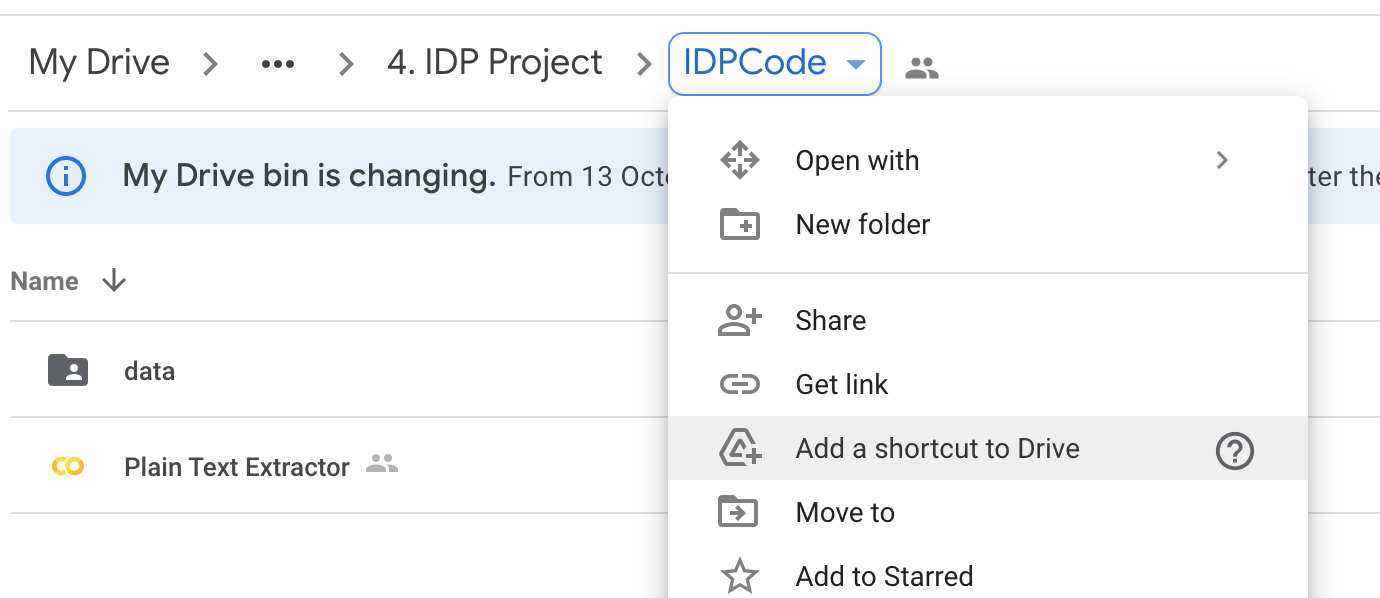
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [ ]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5

# Start from here if you run in local !!

In [1]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/Google Drive/AllPapers'


time: 430 µs


# Data pre-processing

In [2]:
# dt = Dataset Tika
dt = pd.read_pickle('dt_normalized_indexed.pkl') # https://drive.google.com/file/d/1THBPXX4wsHDQDDqImqaTkbGuc_VPzT2J/view?usp=sharing

time: 1.18 s


#### 'dt_normalized.pkl' is created by Python3.8. If you have lower python version, the file could not be read. In this case you case use the same data but created with Python3.6 below:

In [3]:
#picklefile = open('dt_normalized_python36.pkl', 'wb')
#pickle the dataframe
#pickle.dump(dt, picklefile)
#close file
#picklefile.close()

time: 244 µs


In [4]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','', text)
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = text.replace('\n', ' ')
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text):        
  sent = []
  doc = nlp(text)
  for word in doc:
    sent.append(word.lemma_)
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    nlp = spacy.load('en')
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1

time: 1.34 s


## Stopwords

In [5]:
# Find accounting related stop words
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firm','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']

time: 444 µs


## Remove stop words

In [7]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

# Remove stopwords
dt['content_accounting_stop_words'] = dt['content_stop_words'].apply(remove_stopwords)

time: 3.04 s


## Lemmatization

In [9]:
dt['content_lemmatized'] = dt['content_accounting_stop_words'].apply(lemmatizer)
dt['content_lemmatized_clean'] = dt['content_lemmatized'].str.replace('-PRON-', '')

time: 22min 54s


In [10]:
text = dt['content_accounting_stop_words'].head(1)[0]

time: 13 ms


In [11]:
sent = []
doc = nlp(text)
doc

horizons american association vol doi effect characteristics stage adoption experience institutional explanations erp systems choice joseph ugrin synopsis existing studies linkage institutional factors systems adoption literature overlooked important question decision implement influenced institutional factors author argues decisions adopt systems influenced equally institutional factors examines characteristics moderate effects institutional factors adoption decisions specifically decisions adopt enterprise resource plan ning erp systems results study reveal institutional factors mimicry peers compliance industry norms coercion powerful entities influence erp adoption decisions results effects institutional factors adoption decisions amplified participants adopted erp benefits difficult quantify enhances organizational interaction supply chain author contributes institutional theory literature exploring ditions enhance salience institutional factors contributes systems literature inve

time: 211 ms


In [12]:
for word in doc:
  sent.append(word.lemma_)

time: 1.19 ms


## (Skip) Stemming
May lead to confusion, think about that again!!!

In [14]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

time: 2.09 s


In [15]:
dt['content_stemmed'] = dt['content_stop_words'].apply(stem_text)

time: 4min 25s


In [16]:
dt['content_stemmed_lemmatized'] = dt['content_lemmatized_clean'].apply(stem_text)

time: 4min 7s


Difference between `dt['content'].head(1)` and `dt['content_stemmed'].head(1)`
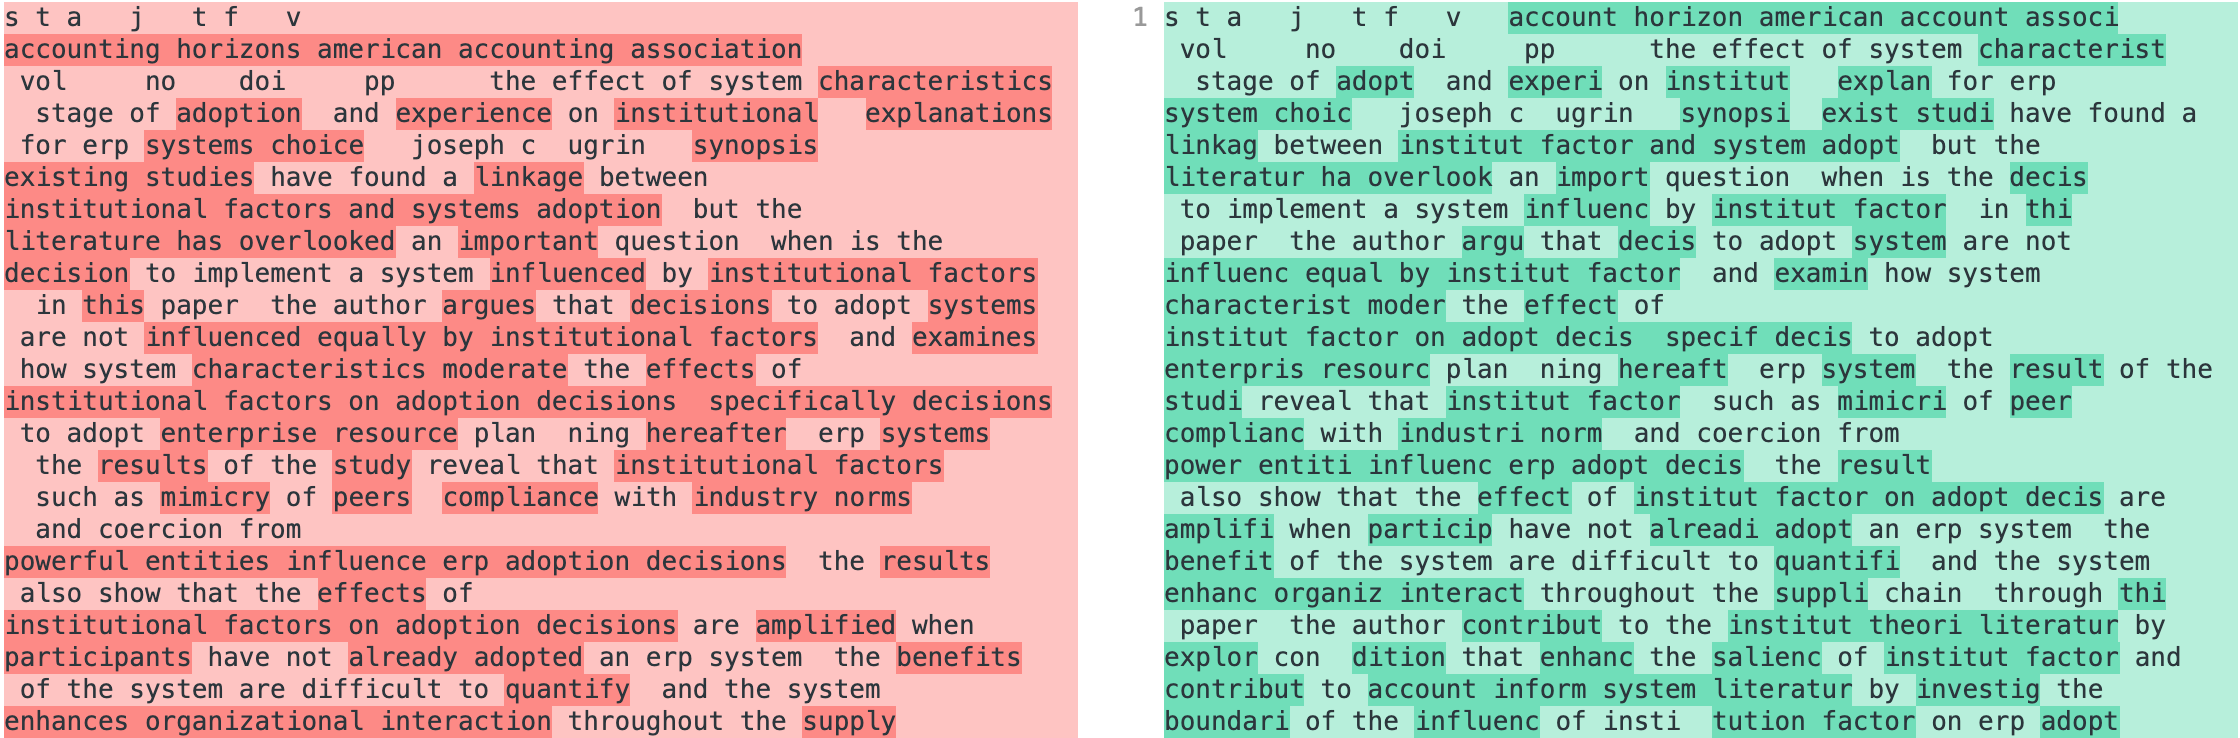

In [17]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'total_page_count', 'content_stop_words', 'content_stemmed', 'content_lemmatized', 'content_lemmatized_clean', 'content_stemmed_lemmatized'])

time: 1.04 s


In [18]:
# dt3c.to_pickle('normalized_indexed_lemmatized.pkl')
dt3c.to_pickle('normalized_indexed_stemmed_lemmatized.pkl')

time: 1.34 s


In [19]:
dt3c.head(1)

file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

   total_page_count  \
0                25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

time: 36.8 ms


In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_stemmed_lemmatized']))

print(wordcloud)

time: 1min 2s


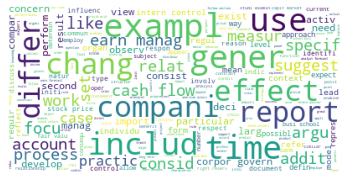

time: 236 ms


In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [22]:
NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 408 µs


## Unigrams

In [23]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_stemmed_lemmatized'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 17.7 s


## Bigrams

In [24]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_stemmed_lemmatized'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 50.1 s


In [25]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_stemmed_lemmatized'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
28     119.070190   64.655502       1        1  8.565292
27      54.382130  109.799164       2        1  6.111039
1     -161.423965 -103.744957       3        1  5.795532
2     -135.370758   36.673065       4        1  5.241187
7      177.317215  -66.872452       5        1  4.866996
14     -16.436356  142.453796       6        1  4.767495
10      31.052383  204.777573       7        1  4.699121
8      -25.024384 -186.083466       8        1  4.625182
16     -68.157486   20.934038       9        1  4.401167
24      -3.751695    4.961509      10        1  4.089006
13    -114.470009 -179.605469      11        1  3.527490
21    -110.729126  -40.476776      12        1  3.400356
22      42.552418  -42.789406      13        1  3.229232
0      -10.661536   71.922211      14        1  3.160922
19     112.652969  -16.279951      15        1  3.053966
9     -195.499146  -25.853945      16        1  2.979176
15    -207.165924   66.070419      17        1  2.792576
29      10.217649 -110.752060      18        1  2.757320
20     -81.255081   96.477776      19        1  2.681810
25     -77.253441  192.755219      20        1  2.487948
3      182.353027  110.412880      21        1  2.353820
5       89.766510  -93.997673      22        1  2.346906
6      -36.483528  -52.542774      23        1  2.081424
4      -72.052170 -112.144821      24        1  2.065577
17     144.822769 -150.811508      25        1  1.986194
23    -148.475357  135.678162      26        1  1.521239
18     189.811615   17.382956      27        1  1.430249
11      56.555355   33.755768      28        1  1.364274
12      58.988537 -178.376541      29        1  0.913335
26     110.556717  164.236694      30        1  0.704171, topic_info=                  Term          Freq         Total Category  logprob  loglift
1404              earn  52030.000000  52030.000000  Default  30.0000  30.0000
2782             manag  73289.000000  73289.000000  Default  29.0000  29.0000
4448               tax  29275.000000  29275.000000  Default  28.0000  28.0000
313            auditor  44965.000000  44965.000000  Default  27.0000  27.0000
4717           univers  51184.000000  51184.000000  Default  26.0000  26.0000
1279         disclosur  29211.000000  29211.000000  Default  25.0000  25.0000
2350            intern  31281.000000  31281.000000  Default  24.0000  24.0000
3346           perform  32651.000000  32651.000000  Default  23.0000  23.0000
965            control  30345.000000  30345.000000  Default  22.0000  22.0000
3809            report  59221.000000  59221.000000  Default  21.0000  21.0000
174            analyst  20058.000000  20058.000000  Default  20.0000  20.0000
1799          forecast  18288.000000  18288.000000  Default  19.0000  19.0000
2804            market  42927.000000  42927.000000  Default  18.0000  18.0000
3514             price  24951.000000  24951.000000  Default  17.0000  17.0000
1950            govern  24125.000000  24125.000000  Default  16.0000  16.0000
4288             stock  21908.000000  21908.000000  Default  15.0000  15.0000
310              audit  23301.000000  23301.000000  Default  14.0000  14.0000
1007           countri  15140.000000  15140.000000  Default  13.0000  13.0000
988             corpor  25815.000000  25815.000000  Default  12.0000  12.0000
3606            public  27775.000000  27775.000000  Default  11.0000  11.0000
3881              risk  30351.000000  30351.000000  Default  10.0000  10.0000
761             client  14669.000000  14669.000000  Default   9.0000   9.0000
42             accrual  11733.000000  11733.000000  Default   8.0000   8.0000
996               cost  33483.000000  33483.000000  Default   7.0000   7.0000
2385          investor  24161.000000  24161.000000  Default   6.0000   6.0000
2239             incom  14700.000000  14700.000000  Default   5.0000   5.0000
2481           journal  207

time: 3min 23s


In [26]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 528 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [27]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme    Topic 1    Topic 2  Topic 3     Topic 4   Topic 5   Topic 6  \
Word 0          corpor      studi     valu     univers    intern   perform   
Word 1          govern     effect    model      associ   control    measur   
Word 2           board      decis    capit       state    report     manag   
Word 3        committe     result   invest    american    extern   employe   
Word 4        director  literatur   return      review     manag    budget   
Word 5         compani     differ     rate      editor       sox     evalu   
Word 6        independ     examin   equiti     journal   section      work   
Word 7          report   influenc     risk        texa    effect       job   
Word 8           manag   individu     cash    workshop      weak     trust   
Word 9          member     experi    estim       thank   auditor      task   
Word 10         execut        use    asset     horizon   compani     organ   
Word 11           role     factor   market         aaa     audit      goal   
Word 12      sharehold     theori     flow      includ    materi   organiz   
Word 13         effect       evid   valuat  california    requir      team   
Word 14         associ   particip   measur         car  function  individu   
Word 15          studi    suggest   growth      econom    provid     skill   
Word 16        monitor     affect  variabl        john      risk     level   
Word 17            cfo    variabl    futur  washington     studi    employ   
Word 18            ceo     import    ratio      colleg       act    effort   
Word 19         requir   investig   financ       avail     organ    result   

topic_theme    Topic 7    Topic 8    Topic 9   Topic 10     Topic 11  \
Word 0             tax      manag     return  disclosur         cost   
Word 1           incom       busi    announc     report        model   
Word 2        dividend   industri     market   investor      product   
Word 3            rate    product     period    disclos        decis   
Word 4            taxi       cost       time    compani          set   
Word 5          effect   strategi  conservat  voluntari        agent   
Word 6          corpor    process       evid     provid        optim   
Word 7           taxat      organ       news     annual         good   
Word 8           avoid    compani        neg        sec       effici   
Word 9           capit     custom     result     releas       invest   
Word 10         revenu  technolog      stock     market     competit   
Word 11            pay       oper      studi      relat       econom   
Word 12           gain    control       year       file      project   
Word 13        increas      activ      chang    content      increas   
Word 14          shift    strateg      event      studi       result   
Word 15         differ    develop      short     corpor      problem   
Word 16          chang        use       earn     requir         high   
Word 17         polici  implement      posit   internet       effect   
Word 18            low     servic    increas     examin        alloc   
Word 19      distribut      chang     abnorm      regul  uncertainti   

topic_theme    Topic 12   Topic 13   Topic 14   Topic 15       Topic 16  \
Word 0           review  ownership       earn   standard          manag   
Word 1           author      share    analyst     report           earn   
Word 2           articl      china   forecast       valu        accrual   
Word 3             tabl   transfer   investor  statement        qualiti   
Word 4           number     chines     expect      asset         report   
Word 5             text       hong      futur       fair  discretionari   
Word 6            paper       kong      stock      incom         afaanz   
Word 7          journal    control    predict     measur        manipul   
Word 8       manuscript  sharehold      error       fasb          studi   
Word 9           includ   institut      price       item           high   
Word 10          editor

time: 118 ms


# 2. Topic Modeling

## 2.1. Term Frequency–Inverse Document Frequency (TF-IDF) Vectorizer

In [28]:
vectorizer = TfidfVectorizer(stop_words = stop_list,
                             ngram_range = (1,1))
doc_word = vectorizer.fit_transform(dt3c['content_stemmed_lemmatized'])

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 10.1 s


In [29]:
vectorizer.get_feature_names()[0:5]

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['aa', 'aaa', 'aaaan', 'aaahorsubm', 'aaahq']

time: 174 ms


In [32]:
lda_model_tfidf = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output_tfidf = lda_model_tfidf.fit_transform(doc_word)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 18min 17s


In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_word, vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ValueError: Negative values in data passed to TSNE.fit(). With metric='precomputed', X should contain positive distances.

time: 34.1 s


In [34]:
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0    Topic 1  Topic 2     Topic 3   Topic 4   Topic 5  \
Word 0      corpor      studi     valu     univers    intern   perform   
Word 1      govern     effect    model      associ   control    measur   
Word 2       board      decis    capit       state    report     manag   
Word 3    committe     result   invest    american    extern   employe   
Word 4    director  literatur   return      review     manag    budget   
Word 5     compani     differ     rate      editor       sox     evalu   
Word 6    independ     examin   equiti     journal   section      work   
Word 7      report   influenc     risk        texa    effect       job   
Word 8       manag   individu     cash    workshop      weak     trust   
Word 9      member     experi    estim       thank   auditor      task   
Word 10     execut        use    asset     horizon   compani     organ   
Word 11       role     factor   market         aaa     audit      goal   
Word 12  sharehold     theori     flow      includ    materi   organiz   
Word 13     effect       evid   valuat  california    requir      team   
Word 14     associ   particip   measur         car  function  individu   
Word 15      studi    suggest   growth      econom    provid     skill   
Word 16    monitor     affect  variabl        john      risk     level   
Word 17        cfo    variabl    futur  washington     studi    employ   
Word 18        ceo     import    ratio      colleg       act    effort   
Word 19     requir   investig   financ       avail     organ    result   

           Topic 6    Topic 7    Topic 8    Topic 9     Topic 10    Topic 11  \
Word 0         tax      manag     return  disclosur         cost      review   
Word 1       incom       busi    announc     report        model      author   
Word 2    dividend   industri     market   investor      product      articl   
Word 3        rate    product     period    disclos        decis        tabl   
Word 4        taxi       cost       time    compani          set      number   
Word 5      effect   strategi  conservat  voluntari        agent        text   
Word 6      corpor    process       evid     provid        optim       paper   
Word 7       taxat      organ       news     annual         good     journal   
Word 8       avoid    compani        neg        sec       effici  manuscript   
Word 9       capit     custom     result     releas       invest      includ   
Word 10     revenu  technolog      stock     market     competit      editor   
Word 11        pay       oper      studi      relat       econom        page   
Word 12       gain    control       year       file      project       figur   
Word 13    increas      activ      chang    content      increas     publish   
Word 14      shift    strateg      event      studi       result      submit   
Word 15     differ    develop      short     corpor      problem      public   
Word 16      chang        use       earn     requir         high        peer   
Word 17     polici  implement      posit   internet       effect       citat   
Word 18        low     servic    increas     examin        alloc     editori   
Word 19  distribut      chang     abnorm      regul  uncertainti     submiss   

          Topic 12   Topic 13   Topic 14       Topic 15   Topic 16   Topic 17  \
Word 0   ownership       earn   standard          manag    compens    journal   
Word 1       share    analyst     report           earn     incent    student   
Word 2       china   forecast       valu        accrual   contract    univers   
Word 3    transfer   investor  statement        qualiti        ceo     financ   
Word 4      chines     expect      asset         report       debt    publish   
Word 5        hong      futur       fair  discretionari      agenc       busi   
Word 6        kong      stock      incom         afaanz  sharehold       educ   
Word 7     control    predict     measur        manipul        pay     academ   
Word 8   sharehold      error       fasb      

time: 76 ms


In [35]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-35-9689e41583c7>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



file_path  \
0   /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
1   /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf   
2   /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf   
3   /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf   
4   /Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf   
5   /Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf   
6   /Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf   
7   /Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf   
8   /Users/farukcankaya/Google Drive/AllPapers/8_AH/152_AH.pdf   
9   /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf   
10  /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf   
11  /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf   
12  /Users/farukcankaya/Google Drive/AllPapers/8_AH/286_AH.pdf   
13  /Users/farukcankaya/Google Drive/AllPapers/8_AH/760_AH.pdf   
14   /Users/farukcankaya/Google Drive/AllPapers/8_AH/70_AH.pdf   

    dominant_topic dominant_topic_theme  
0                7              Topic 7  
1               27             Topic 27  
2               22             Topic 22  
3               28             Topic 28  
4                0              Topic 0  
5               13             Topic 13  
6               21             Topic 21  
7               24             Topic 24  
8               14             Topic 14  
9                7              Topic 7  
10              11             Topic 11  
11               4              Topic 4  
12              17             Topic 17  
13               2              Topic 2  
14               3              Topic 3

time: 15.7 s


## Make Prediction

In [36]:
print(lda_output.shape) # (11682, 8)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape) # (11682, 1)

(11682, 30)
(11682, 1)
time: 50.5 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [37]:
column_names = ['file_path', 'total_page_count', 'content_stop_words', 'content_stemmed', 'content_lemmatized', 'content_lemmatized_clean','content_stemmed_lemmatized'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'total_page_count', 'content_stop_words', 'content_stemmed', 'content_lemmatized', 'content_lemmatized_clean', 'content_stemmed_lemmatized']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 14.1 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [38]:
doc_topic_df.columns = column_names

time: 572 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [39]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

   total_page_count  \
0                25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

time: 54 ms


In [40]:
doc_topic_df.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   file_path                   11682 non-null  object 
 1   total_page_count            11682 non-null  int64  
 2   content_stop_words          11682 non-null  object 
 3   content_stemmed             11682 non-null  object 
 4   content_lemmatized          11682 non-null  object 
 5   content_lemmatized_clean    11682 non-null  object 
 6   content_stemmed_lemmatized  11682 non-null  object 
 7   Topic 1                     11682 non-null  float64
 8   Topic 2                     11682 non-null  float64
 9   Topic 3                     11682 non-null  float64
 10  Topic 4                     11682 non-null  float64
 11  Topic 5                     11682 non-null  float64
 12  Topic 6                     11682 non-null  float64
 13  Topic 7                     116

In [41]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 4.56 s


In [42]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   file_path                   11682 non-null  object 
 1   total_page_count            11682 non-null  int64  
 2   content_stop_words          11682 non-null  object 
 3   content_stemmed             11682 non-null  object 
 4   content_lemmatized          11682 non-null  object 
 5   content_lemmatized_clean    11682 non-null  object 
 6   content_stemmed_lemmatized  11682 non-null  object 
 7   Topic 1                     11682 non-null  float64
 8   Topic 2                     11682 non-null  float64
 9   Topic 3                     11682 non-null  float64
 10  Topic 4                     11682 non-null  float64
 11  Topic 5                     11682 non-null  float64
 12  Topic 6                     11682 non-null  float64
 13  Topic 7                     116

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
Topic 1                                                    4.3802e-05   
Topic 2                                                      0.280901   
Topic 3                                                    4.3802e-05   
Topic 4                                                     0.0604519   
Topic 5                                                    4.3802e-05   
Topic 6                                                    4.3802e-05   
Topic 7                                                    4.3802e-05   
Topic 8                                                      0.289178   
Topic 9                                                    4.3802e-05   
Topic 10                                                   4.3802e-05   
Topic 11                                                   4.3802e-05   
Topic 12                                                   0.00761785   
Topic 13                                                   4.3802e-05   
Topic 14                                                   4.3802e-05   
Topic 15                                                   4.3802e-05   
Topic 16                                                   4.3802e-05   
Topic 17                                                   4.3802e-05   
Topic 18                                                   4.3802e-05   
Topic 19                                                   4.3802e-05   
Topic 20                                                     0.117599   
Topic 21                                                   4.3802e-05   
Topic 22                                                   4.3802e-05   
Topic 23                                                    0.0455502   
Topic 24                                                   4.3802e-05   
Topic 25                                                   4.3802e-05   
Topic 26                                                   4.3802e-05   
Topic 27                                                   4.3802e-05   
Topic 28                                                   4.3802e-05   
Topic 29                                                     0.127758   
Topic 30                                                    0.0699797   

                                                                    1  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf   
Topic 1                                                     0.0131724   
Topic 2                                                   4.48632e-05   
Topic 3                                                    0.00676213   
Topic 4                                                       0.15681   
Topic 5                                                   4.48632e-05   
Topic 6                                                     0.0237363   
Topic 7                                                   4.48632e-05   
Topic 8                                                      0.151644   
Topic 9                                                   4.48632e-05   
Topic 10                                                  4.48632e-05   
Topic 11                                                    0.0712662   
Topic 12                                                  4.48632e-05   
Topic 13                                                  4.48632e-05   
Topic 14                                                  4.48632e-05   
Topic 15                                                  4.48632e-05   
Topic 16                                                  4.48632e-05   
Topic 17                                                  4.48632e-05   
Topic 18                                                     0.220947   
Topic 19                                                  4.48632e-05   
Topic 20                                                  4.48632e-05   
Topic 21                                                  4.48632e-05   
Topic 22                                            

time: 20.8 ms


In [44]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(11682, 30)
[4.38020149e-05 2.80900789e-01 4.38020149e-05 6.04519075e-02
 4.38020149e-05 4.38020149e-05 4.38020149e-05 2.89178449e-01
 4.38020149e-05 4.38020149e-05 4.38020149e-05 7.61784795e-03
 4.38020149e-05 4.38020149e-05 4.38020149e-05 4.38020149e-05
 4.38020149e-05 4.38020149e-05 4.38020149e-05 1.17599439e-01
 4.38020149e-05 4.38020149e-05 4.55501695e-02 4.38020149e-05
 4.38020149e-05 4.38020149e-05 4.38020149e-05 4.38020149e-05
 1.27758058e-01 6.99796960e-02]
time: 10.7 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [69]:
norms = np.linalg.norm(topic_array, axis = 1)

def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 136 ms


In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
    
    nlp = spacy.load('en', disable=['parser', 'ner'])

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Remove stop words
    for i in range(len(text)):
      text[i] = remove_stopwords(clean_text(text[i]))
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    print(mytext_3[0][0:100]+" ...")
    
    mytext_3_1 = []
    for t in mytext_3:
      mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3_1)
    
    print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    print('Vectorized data {}'.format(data_vectorized.shape))
    print('First 100 Feature names:')
    print(count_vectorizer.get_feature_names()[:100])
    print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 1.79 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [85]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = AOS_3)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Text after lemmatization (3737 characters):
focused way inter relation control draw tracting theory model build management control structure rel ...
Count vectorizer of transformed text: (1, 5000)
Vectorized data (11682, 5000)
First 100 Feature names:
['aaa', 'aaaj', 'aaanz', 'aaer', 'aasb', 'abandon', 'abarbanel', 'abbott', 'abbrevi', 'abc', 'abdel', 'aberdeen', 'abernethi', 'abil', 'abl', 'abnorm', 'aboodi', 'abroad', 'absenc', 'absent', 'absolut', 'absorb', 'abstract', 'abus', 'aca', 'academ', 'academi', 'academia', 'acc', 'acca', 'acceler', 'accept', 'access', 'accommod', 'accompani', 'accomplish', 'accord', 'accordingli', 'accoun', 'account', 'accredit', 'accru', 'accrual', 'accumul', 'accur', 'accuraci', 'accus', 'achiev', 'acknowledg', 'acquir', 'acquisit', 'act', 'action', 'actionnair', 'activ', 'activist', 'activit', 'actor', 'actual', 'actuari', 'acut', 'adam', 'adapt', 'add', 'addi', 'addit', 'address', 'adelaid', 'adequ', 'adequaci', 'adher', 'adjust', 'adler', 'administ', 

file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 2.06 s


In [82]:
doc_topic_df.isna().sum().sum()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0

time: 2.44 s


In [66]:
doc_topic_df.isna().head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  total_page_count  content_stop_words  content_stemmed  \
0      False             False               False            False   
1      False             False               False            False   
2      False             False               False            False   
3      False             False               False            False   
4      False             False               False            False   

   content_lemmatized  content_lemmatized_clean  content_stemmed_lemmatized  \
0               False                     False                       False   
1               False                     False                       False   
2               False                     False                       False   
3               False                     False                       False   
4               False                     False                       False   

   Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  \
0    False    False    False    False    False    False    False    False   
1    False    False    False    False    False    False    False    False   
2    False    False    False    False    False    False    False    False   
3    False    False    False    False    False    False    False    False   
4    False    False    False    False    False    False    False    False   

   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  Topic 14  Topic 15  \
0    False     False     False     False     False     False     False   
1    False     False     False     False     False     False     False   
2    False     False     False     False     False     False     False   
3    False     False     False     False     False     False     False   
4    False     False     False     False     False     False     False   

   Topic 16  Topic 17  Topic 18  Topic 19  Topic 20  Topic 21  Topic 22  \
0     False     False     False     False     False     False     False   
1     False     False     False     False     False     False     False   
2     False     False     False     False     False     False     False   
3     False     False     False     False     False     False     False   
4     False     False     False     False     False     False     False   

   Topic 23  Topic 24  Topic 25  Topic 26  Topic 27  Topic 28  Topic 29  \
0     False     False     False     False     False     False     False   
1     False     False     False     False     False     False     False   
2     False     False     False     False     False     False     False   
3     False     False     False     False     False     False     False   
4     False     False     False     False     False     False     False   

   Topic 30  
0     False  
1     False  
2     False  
3     False  
4     False

time: 43.2 ms


In [67]:
np.isnan(lda_output).any()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



False

time: 3.39 ms


In [68]:
topic_sum.isna().sum()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    0
dtype: int64

time: 3.56 ms


In [79]:
doc_topic_df['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0             /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf
1             /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf
2             /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf
3             /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf
4             /Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf
5             /Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf
6             /Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf
7             /Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf
8             /Users/farukcankaya/Google Drive/AllPapers/8_AH/152_AH.pdf
9             /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf
10            /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf
11            /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf
12            /Users/farukcankaya/Google Drive/AllPapers/8_AH/286_AH.pdf
13            /Users/farukcankaya/Google Drive/AllP

time: 174 ms
